In [1]:
import glob

import numpy as np

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

from itertools import cycle
from sklearn.metrics import roc_curve, auc

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from tqdm.notebook import tqdm

from torch_geometric.explain import Explainer, GNNExplainer

import xai4hep

# Get dataset

In [2]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")

    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data


dataset_path = "/global/cfs/cdirs/ntrain2/data/toptagging/"

test_dataset = load_data(dataset_path, "test", n_files=1)  # use test directory because it contains subjet info
val_dataset = load_data(dataset_path, "val", n_files=1)

--- loaded file 0 from `test` directory
--- loaded file 0 from `val` directory


## Explore dataset

In [3]:
test_dataset[:10]

[Data(x=[17, 7], y=0, px=[17], py=[17], pz=[17], E=[17]),
 Data(x=[61, 7], y=0, px=[61], py=[61], pz=[61], E=[61]),
 Data(x=[45, 7], y=0, px=[45], py=[45], pz=[45], E=[45]),
 Data(x=[74, 7], y=0, px=[74], py=[74], pz=[74], E=[74]),
 Data(x=[30, 7], y=0, px=[30], py=[30], pz=[30], E=[30]),
 Data(x=[37, 7], y=0, px=[37], py=[37], pz=[37], E=[37]),
 Data(x=[79, 7], y=0, px=[79], py=[79], pz=[79], E=[79]),
 Data(x=[41, 7], y=0, px=[41], py=[41], pz=[41], E=[41]),
 Data(x=[92, 7], y=0, px=[92], py=[92], pz=[92], E=[92]),
 Data(x=[17, 7], y=0, px=[17], py=[17], pz=[17], E=[17])]

In [4]:
test_dataset[0].x

tensor([[-1.9442e-02,  9.3275e-02,  5.3207e+00,  5.3862e+00, -1.0834e+00,
         -1.0833e+00,  9.5280e-02],
        [ 5.8873e-03, -3.4971e-02,  4.9779e+00,  5.0347e+00, -1.4262e+00,
         -1.4347e+00,  3.5463e-02],
        [ 2.7067e-02, -2.2574e-02,  4.2899e+00,  4.3400e+00, -2.1142e+00,
         -2.1295e+00,  3.5245e-02],
        [ 3.8218e-02, -2.3472e-02,  4.1150e+00,  4.1617e+00, -2.2891e+00,
         -2.3078e+00,  4.4851e-02],
        [-5.3362e-03, -3.5016e-02,  3.9994e+00,  4.0600e+00, -2.4047e+00,
         -2.4095e+00,  3.5420e-02],
        [ 1.7531e-02, -2.8692e-02,  3.5385e+00,  3.5916e+00, -2.8656e+00,
         -2.8778e+00,  3.3624e-02],
        [ 2.0561e-01, -6.5708e-01,  2.3877e+00,  2.3976e+00, -4.0164e+00,
         -4.0719e+00,  6.8849e-01],
        [-8.0407e-02, -2.2516e-02,  1.5615e+00,  1.6500e+00, -4.8426e+00,
         -4.8195e+00,  8.3500e-02],
        [-9.8348e-02, -6.3129e-02,  1.5044e+00,  1.6002e+00, -4.8997e+00,
         -4.8693e+00,  1.1687e-01],
        [ 

In [11]:
test_loader = DataLoader(test_dataset, batch_size=128)
val_loader =  DataLoader(val_dataset, batch_size=128)

# Get model

In [ ]:
# the actual particlenet model can be imported via `xai4hep.particlenet import ParticleNet`
# the model is below is a simplified one

import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor


class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        depth=1,
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.fc_size = 256

        # define the edgeconvblocks
        self.edge_conv_block = EdgeConvBlock(node_feat_size, 256, depth=depth)

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(node_feat_size + 256, self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch=None):
        # input transformations
        x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
        x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
        x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
        x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
        x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        # useful placeholders for LRP studies
        out = self.edge_conv_block(x, edge_index)
        x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        if batch is None:
            x = x.sum(axis=0)
        else:
            x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sig(x)

        return x


# setup the input/output dimension of the model
k = 12

model_kwargs = {
    "node_feat_size": 7,
    "num_classes": 1,
    "depth": 3,
}

model = ParticleNet(**model_kwargs)

In [18]:
# train the model
def train(loader, model, idx=100):
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i, batch in enumerate(loader):
        edge_index = knn_graph(batch.x[:, :2], k, batch.batch)

        preds = model(batch.x, edge_index, batch.batch)

        # compute the invariance loss which is contrained by the other loss terms
        loss = criterion(preds, batch.y.unsqueeze(-1).float())

        # backprop
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        optimizer.step()
        if i % 10 == 0: print(f"loss on batch {i}: {loss.detach()}")

        if i == idx:
            break

train(val_loader, model, idx=100)

loss on batch 0: 0.2552562355995178
loss on batch 10: 0.2566799819469452
loss on batch 20: 0.3038439154624939
loss on batch 30: 0.27487996220588684
loss on batch 40: 0.30648714303970337
loss on batch 50: 0.3159771263599396
loss on batch 60: 0.24372749030590057
loss on batch 70: 0.23077428340911865
loss on batch 80: 0.21528470516204834
loss on batch 90: 0.20582109689712524
loss on batch 100: 0.369211345911026


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

271105

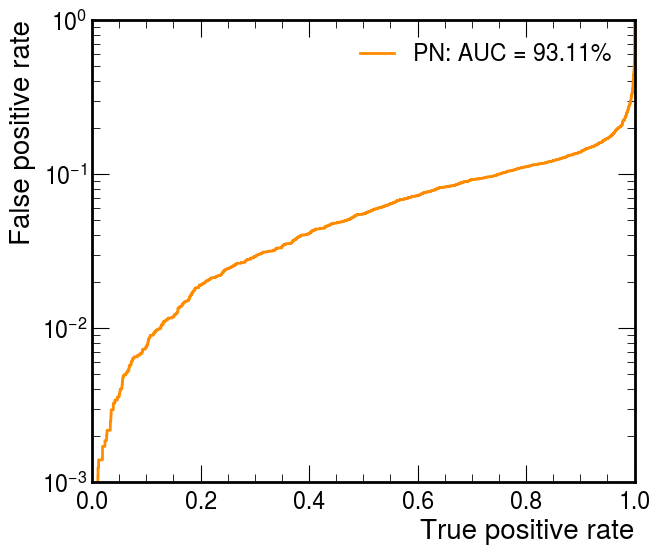

In [24]:
# test
@torch.no_grad()
def test(loader, model, idx=100):
    model.eval()
    targets_ = []
    preds_ = []
    for i, batch in enumerate(loader):
        edge_index = knn_graph(batch.x[:, :2], k)

        preds_ += model(batch.x, edge_index, batch.batch).tolist()
        targets_ += batch.y.tolist()

        if i == idx:
            break
    return preds_, targets_

preds_, targets_ = test(test_loader, model, idx=100)

fig, ax = plt.subplots(figsize=[7, 6])

fpr, tpr, _ = roc_curve(targets_, preds_)
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"PN: AUC = {round(auc(fpr, tpr)*100,2)}%",
)

plt.xlim([0.0, 1.0])
plt.ylim([1e-3, 1.0])
plt.ylabel("False positive rate")
plt.xlabel("True positive rate")
plt.yscale("log")
plt.legend()
plt.show()

## Real training

In [26]:
! python -m xai4hep.particlenet.run_training --quick --model_prefix=ParticleNet_model --dataset /global/cfs/cdirs/ntrain2/data/toptagging --outpath $PWD/experiments

Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB
Device 2: NVIDIA A100-SXM4-40GB
Device 3: NVIDIA A100-SXM4-40GB
ParticleNet(
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, 

## Calculate LRP scores

In [27]:
! python -m xai4hep.run_lrp_particlenet --quick --model_prefix=ParticleNet_model --run_lrp --make_dr_Mij_plots --scaling_up --dataset /global/cfs/cdirs/ntrain2/data/toptagging --outpath $PWD/experiments

Will use GPU model: NVIDIA A100-SXM4-40GB
Runing the LRP pipeline to compute the Rscores for the model at epoch -1
- loading datafiles for lrp studies...
--- loading only 1000 events for quick test
ParticleNet(
  (edge_conv_blocks): ModuleList(
    (0): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=14, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      ))
    )
    (1): EdgeConvBlock(
      (edge_conv): EdgeConv_lrp(nn=Sequential(
        (0): Linear(in_features=142, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True